In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the scattering of only one photon towards a 2-level atom. Also, I assume that several atoms might be in the waveguide (to play the role of a mirror for instance). I work in the subspace :

$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h1> Data generation </h1>

Encode a big function the state accross the evolution, the occupation number, and the overlap with the symmetrical state

In [3]:
def generate_data_2d(L, lenght_mirror,layers,n_A_one_layer, sigma, x_0, y_0, g_0, omega_A, omega_0, omega_max, T, dt, position_basis=None):
    ###Problem parameters

    #position of the atoms
    print("Preparing the position of the atoms ...")
    spacing_atom = lenght_mirror / (np.sqrt(2)**2 * n_A_one_layer)
    if n_A_one_layer % 2 == 0:
        raise ValueError("n_A must be an odd number to have a central atom at the origin.")
    
    n_A = layers * n_A_one_layer
    position_atom_list = np.zeros((n_A, 2))
    position_atom_list[n_A_one_layer//2] = [0,0]
    
    
    for i in range(1, n_A_one_layer//2+1):
        position_atom_list[n_A_one_layer//2 - i] = [-i*spacing_atom, -i*spacing_atom]
        position_atom_list[n_A_one_layer//2 + i] = [i*spacing_atom, i*spacing_atom]
    
    if layers > 1:
        for layer in range(1, layers):
            for i in range(n_A_one_layer):
                position_atom_list[n_A_one_layer*layer + i] = position_atom_list[n_A_one_layer*(layer-1) + i] + np.array([spacing_atom / np.sqrt(2), -1*spacing_atom / np.sqrt(2)])

    #prepare the momentum space
    dp = 2*pi/L
    omega_tab_p = np.array([dp*n for n in range(1000000) if dp*n <= omega_max])
    kx_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    ky_tab = np.copy(kx_tab)
    n_modes = len(kx_tab)
    print("Number of modes in momentum space: ", n_modes, " X ", n_modes)
    dim_subspace = n_modes**2 + n_A

    ### Encode the Hamiltonian
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    #diagonal elements
    dummy_index = 0
    for i in range(n_modes):
        for j in range(n_modes):
            H_matrix[dummy_index, dummy_index] = np.sqrt(kx_tab[i]**2 + ky_tab[j]**2)
            dummy_index += 1

    for j in range(n_A):
        H_matrix[n_modes**2+j, n_modes**2+j] = omega_A

    #off-diagonal elements
    dummy_index_0 = 0
    for i in range(n_modes):
        for j in range(n_modes):
            dummy_index_1 = n_modes**2
            for k in range(n_A):
                position_atom = position_atom_list[k]
                k_vector = np.array([kx_tab[i], ky_tab[j]])
                H_matrix[dummy_index_1, dummy_index_0] = 1j*g_0*np.sqrt(omega_A)/L * np.exp(-1j*np.dot(k_vector, position_atom))
                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                dummy_index_1 += 1

            dummy_index_0 += 1

    H = qt.Qobj(H_matrix)

    ###Encode the initial state in qutip
    print("Preparing the initial state ...")
    coef_momentum = np.zeros((n_modes, n_modes), dtype=complex)
    k_bar = np.array([omega_0, 0])
    r_bar = np.array([x_0, y_0])

    init_state = 0
    dummy_index = 0
    for i in range(n_modes):
        for j in range(n_modes):
            k_vector = np.array([kx_tab[i], ky_tab[j]])
            coef_momentum[i, j] = np.exp(-0.5*sigma**2*np.linalg.norm(k_vector - k_bar)**2 - 1j*np.dot(k_vector, r_bar))
            init_state += coef_momentum[i, j]*qt.basis(dim_subspace, dummy_index)
            dummy_index += 1
    init_state = init_state.unit()


    ###Now conduct the time evolution
    print("Starting the time evolution ...")
    n_step = int(T/dt)
    t_list = np.linspace(0, T, n_step)

    result = qt.sesolve(H, init_state, t_list, options={"nsteps":10000, "progress_bar":True, "store_states":True})
    state_list = result.states

    ###Compute the quantities of interest
    N_k_t = np.zeros((n_modes, n_modes, n_step))
    N_A_t = np.zeros((n_step, 1))
    
    print("Computing occupation numbers in momentum space...")
    for t in tqdm(range(n_step)):
        current_state = state_list[t]

        dummy_index = 0
        for i in range(n_modes):
            for j in range(n_modes):
                momentum_state = qt.basis(dim_subspace, dummy_index)
                N_k_t[i, j, t] = np.abs(momentum_state.dag() * current_state)**2
                dummy_index += 1

        for k in range(n_A):
            atomic_state = qt.basis(dim_subspace, n_modes**2+k)
            N_A_t[t] += np.abs(atomic_state.dag() * current_state)**2
    
    if position_basis is None:
        N_x_t = None
    else:
        N = position_basis.shape[0]
        N_x_t = np.zeros((N, N, n_step))
        print("Computing occupation numbers in position space...")
        for t in tqdm(range(n_step)):
            current_state = state_list[t]
            for i in range(N):
                for j in range(N):
                    position_state = qt.Qobj(position_basis[i, j])
                    N_x_t[i, j, t] = np.abs(position_state.dag() * current_state)**2
    
    ###Compute reflection and transmission coefficients
    P_x_t = np.zeros((n_step, 1))
    P_y_t = np.zeros((n_step, 1))
    for t in range(n_step):
        for i in range(n_modes):
            for j in range(n_modes):
                if kx_tab[i] > ky_tab[j]:
                    P_x_t[t] += N_k_t[i, j, t]
                else:
                    P_y_t[t] += N_k_t[i, j, t]
    
    return t_list, position_atom_list, N_k_t, N_x_t, N_A_t, P_x_t, P_y_t

Check the parameters

In [13]:
L = 10*pi
T = L/2
dt = 0.1

#width of the wave packet
sigma = L/8
sigma_momentum = 1/sigma
x_0 = -L/4


#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.05
omega_A = 3
gamma = 2*g_0**2*omega_A**2

omega_0_m = omega_A - gamma
omega_0_p = omega_A + gamma

#resolution of the mirror 
n_A = 49
layers = 1
length_mirror = np.sqrt(2)*L / 2
spacing_prediction = length_mirror / n_A
wave_lenght_photon = 2*pi / omega_A

print("Spacing between atoms: ", spacing_prediction)
print("Wave length of the photons at resonance: ", wave_lenght_photon)
print("----------------------------------")

print("Delta_k / Gamma: ", sigma_momentum/gamma)

value_to_check = g_0*np.sqrt(omega_A)/L
if value_to_check > 0.1:
    print("Warning: coupling too large")
print("Coupling g: ", g_0*np.sqrt(omega_A)/L)
print("omega_0_m = ", omega_0_m, " and omega_0_p = ", omega_0_p)

#define momentum space parameters
omega_0 = 2.7
omega_max = 2*omega_A
x_0 = -L/4
y_0 = 0

#ONLY IF NEEDED : position basis
N = 32
generate_position_basis = False

if generate_position_basis:
    
    #get back the momentum space basis
    dp = 2*pi/L
    omega_tab_p = np.array([dp*n for n in range(1000000) if dp*n <= omega_max])
    kx_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    ky_tab = np.copy(kx_tab)
    n_modes = len(kx_tab)
    dim_subspace = n_modes**2 + n_A

    #prepare the position basis
    print("Preparing the position basis ...")
    x = np.linspace(-L/2, L/2, N)
    y = np.linspace(-L/2, L/2, N)
    position_basis = np.zeros((N, N, dim_subspace ), dtype=complex)
    pbar = tqdm(total=N**2)
    for i in range(N):
        for j in range(N):
            position_state = 0
            dummy_index = 0
            for a in range(n_modes):
                for b in range(n_modes):
                    k_vector = np.array([kx_tab[a], ky_tab[b]])
                    position_state += np.exp(-1j*np.dot(k_vector, [x[i], y[j]])) * qt.basis(dim_subspace, dummy_index)
                    dummy_index += 1
            position_state = position_state.unit()
            position_basis[i, j] = position_state.full().flatten()
            pbar.update(1)

    pbar.close()

Spacing between atoms:  0.4533554018528945
Wave length of the photons at resonance:  2.0943951023931953
----------------------------------
Delta_k / Gamma:  5.658842421045166
Coupling g:  0.0027566444771089603
omega_0_m =  2.955  and omega_0_p =  3.045


First test of the function

In [14]:
if generate_position_basis:
    t_list, position_atom_list, N_k_t, N_x_t, N_A_t, P_x_t, P_y_t = generate_data_2d(L, length_mirror, layers, n_A, sigma, x_0, y_0, g_0, omega_A, omega_0, omega_max, T, dt, position_basis=position_basis)
else:
    t_list, position_atom_list, N_k_t, N_x_t, N_A_t, P_x_t, P_y_t = generate_data_2d(L, length_mirror, layers, n_A, sigma, x_0, y_0, g_0, omega_A, omega_0, omega_max, T, dt)

Preparing the position of the atoms ...
Number of modes in momentum space:  61  X  61
Preparing the initial state ...
Starting the time evolution ...
10.3%. Run time:   0.21s. Est. time left: 00:00:00:01
20.5%. Run time:   0.41s. Est. time left: 00:00:00:01
30.1%. Run time:   0.60s. Est. time left: 00:00:00:01
40.4%. Run time:   0.77s. Est. time left: 00:00:00:01
50.0%. Run time:   0.94s. Est. time left: 00:00:00:00
60.3%. Run time:   1.13s. Est. time left: 00:00:00:00
70.5%. Run time:   1.30s. Est. time left: 00:00:00:00
80.1%. Run time:   1.47s. Est. time left: 00:00:00:00
90.4%. Run time:   1.64s. Est. time left: 00:00:00:00
100.0%. Run time:   1.81s. Est. time left: 00:00:00:00
Total run time:   1.81s
Computing occupation numbers in momentum space...


  0%|          | 0/157 [00:00<?, ?it/s]

<h2> Definition of the reflection coefficient </h2>

I want to define the analogue of the probabilities $P_+$ and $P_-$ I used in 1d. I define:

$$P_y = \sum_{k_y > k_y} N_k \,\, , \,\, P_x = \sum_{k_y < k_x} N_k$$

In case of perfect reflection, I should obtain $P_y =1, P_x = 0$ and if the atom remains unexcited, I have $P_x + P_y = 1$

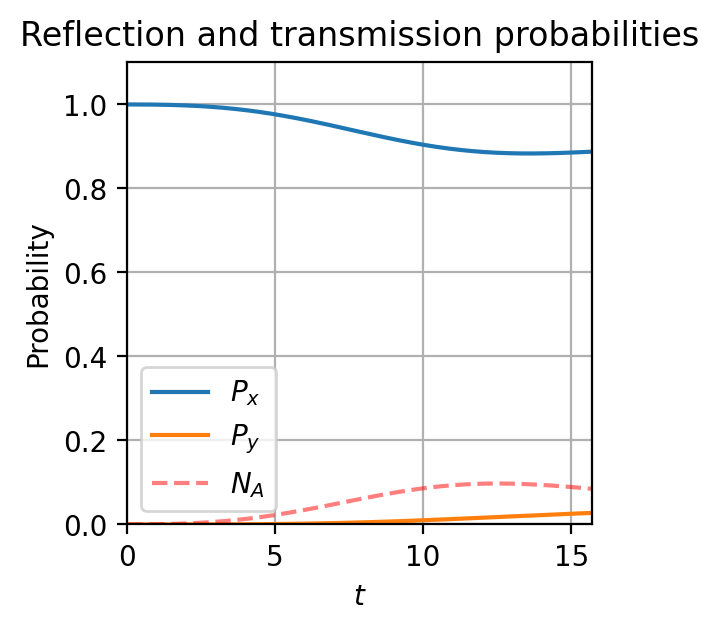

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=200)
ax.plot(t_list, P_x_t, label=r"$P_x$")
ax.plot(t_list, P_y_t, label=r"$P_y$")
ax.plot(t_list, N_A_t, label=r"$N_A$", linestyle='--', alpha=0.5, color="red")
ax.set_xlabel(r"$t$")
ax.set_xlim(0, T)
ax.set_ylim(0, 1.1)
ax.set_ylabel("Probability")
ax.set_title("Reflection and transmission probabilities")
ax.grid()
ax.legend()

plt.show()

<h2> Wave function </h2>

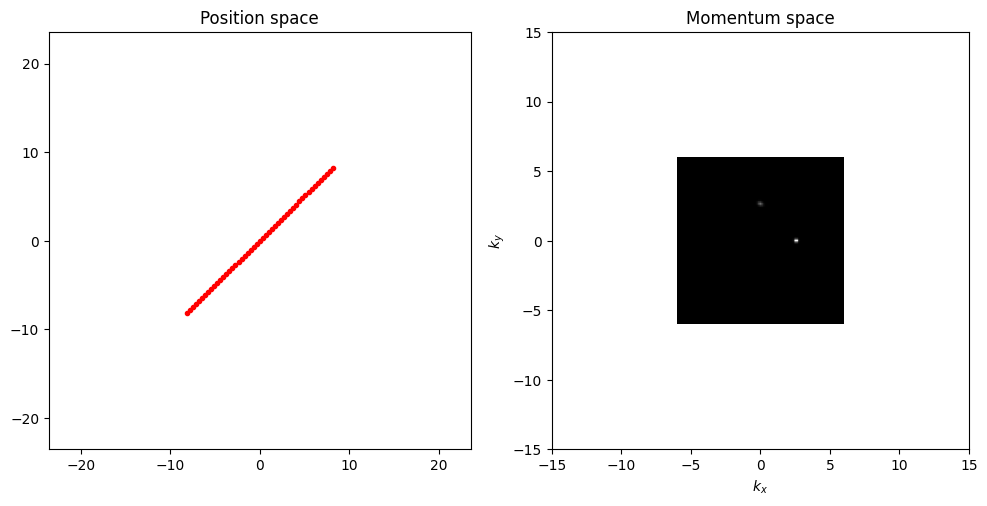

In [47]:
t_index = -1
fig, ax = plt.subplots(1, 2, figsize=(10,5))

##position space plot

if N_x_t is not None:
    position_space_plot = np.transpose(N_x_t[:, :, t_index])
    ax[0].imshow(position_space_plot, extent=[-L/2, L/2, -L/2, L/2], origin='lower', cmap='gray')
    ax[0].set_xlabel(r"$x$")
    ax[0].set_ylabel(r"$y$")

#show the position of the atoms
for pos in position_atom_list:
    ax[0].plot(pos[0], pos[1], 'ro', markersize=3)
ax[0].set_xlim([-L/2, L/2])
ax[0].set_ylim([-L/2, L/2])
ax[0].set_title("Position space")

##momentum space plot
omega_max_axis = 5*omega_A
wave_fct_momentum_plot = np.transpose(N_k_t[:, :, t_index])

ax[1].imshow(np.abs(wave_fct_momentum_plot)**2, extent=[-1*omega_max, omega_max, -1*omega_max, omega_max], origin='lower', cmap='gray')
ax[1].set_xlim([-1*omega_max_axis, omega_max_axis])
ax[1].set_ylim([-1*omega_max_axis, omega_max_axis])
ax[1].set_xlabel(r"$k_x$")
ax[1].set_ylabel(r"$k_y$")
ax[1].set_title("Momentum space")


fig.tight_layout()
plt.show()

<h1> Check reflection against detunning </h1>

In [ ]:
L = 15*pi
T = L/2
dt = 0.1

#width of the wave packet
sigma = L/32
sigma_momentum = 1/sigma
x_0 = -L/4


#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.5
omega_A = 5

omega_0_tab = np.linspace(0.5*omega_A, 1.5*omega_A, 10)
reflection_coeff = np.zeros(len(omega_0_tab))
transmission_coeff = np.zeros(len(omega_0_tab))

for i in tqdm(range(len(omega_0_tab))):
    omega_0 = omega_0_tab[i]
    t_list, N_k_t, N_A_t, overlap_t, P_x_t, P_y_t = generate_data_2d(L, dx, n_A, sigma, x_0, y_0, g_0, omega_A, omega_0, omega_max, T, dt)
    reflection_coeff[i] = P_y_t[-1]
    transmission_coeff[i] = P_x_t[-1]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.09s. Est. time left: 00:00:00:09
20.1%. Run time:   2.01s. Est. time left: 00:00:00:07
30.3%. Run time:   2.95s. Est. time left: 00:00:00:06
40.2%. Run time:   3.84s. Est. time left: 00:00:00:05
50.0%. Run time:   4.74s. Est. time left: 00:00:00:04
60.3%. Run time:   5.68s. Est. time left: 00:00:00:03
70.1%. Run time:   6.59s. Est. time left: 00:00:00:02
80.3%. Run time:   7.53s. Est. time left: 00:00:00:01
90.2%. Run time:   8.43s. Est. time left: 00:00:00:00
100.0%. Run time:   9.35s. Est. time left: 00:00:00:00
Total run time:   9.35s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

/var/folders/ds/7w970h197d59hh_2dj4ry5qw0000gn/T/ipykernel_1853/3290747933.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reflection_coeff[i] = P_x_t[-1]
/var/folders/ds/7w970h197d59hh_2dj4ry5qw0000gn/T/ipykernel_1853/3290747933.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transmission_coeff[i] = P_y_t[-1]


Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.07s. Est. time left: 00:00:00:09
20.1%. Run time:   2.05s. Est. time left: 00:00:00:08
30.3%. Run time:   3.05s. Est. time left: 00:00:00:07
40.2%. Run time:   4.00s. Est. time left: 00:00:00:05
50.0%. Run time:   4.94s. Est. time left: 00:00:00:04
60.3%. Run time:   5.94s. Est. time left: 00:00:00:03
70.1%. Run time:   6.88s. Est. time left: 00:00:00:02
80.3%. Run time:   7.88s. Est. time left: 00:00:00:01
90.2%. Run time:   8.83s. Est. time left: 00:00:00:00
100.0%. Run time:   9.78s. Est. time left: 00:00:00:00
Total run time:   9.78s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.15s. Est. time left: 00:00:00:10
20.1%. Run time:   2.17s. Est. time left: 00:00:00:08
30.3%. Run time:   3.23s. Est. time left: 00:00:00:07
40.2%. Run time:   4.26s. Est. time left: 00:00:00:06
50.0%. Run time:   5.28s. Est. time left: 00:00:00:05
60.3%. Run time:   6.35s. Est. time left: 00:00:00:04
70.1%. Run time:   7.41s. Est. time left: 00:00:00:03
80.3%. Run time:   8.48s. Est. time left: 00:00:00:02
90.2%. Run time:   9.51s. Est. time left: 00:00:00:01
100.0%. Run time:  10.52s. Est. time left: 00:00:00:00
Total run time:  10.53s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.22s. Est. time left: 00:00:00:10
20.1%. Run time:   2.32s. Est. time left: 00:00:00:09
30.3%. Run time:   3.48s. Est. time left: 00:00:00:07
40.2%. Run time:   4.59s. Est. time left: 00:00:00:06
50.0%. Run time:   5.68s. Est. time left: 00:00:00:05
60.3%. Run time:   6.82s. Est. time left: 00:00:00:04
70.1%. Run time:   7.91s. Est. time left: 00:00:00:03
80.3%. Run time:   9.09s. Est. time left: 00:00:00:02
90.2%. Run time:  10.21s. Est. time left: 00:00:00:01
100.0%. Run time:  11.31s. Est. time left: 00:00:00:00
Total run time:  11.31s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.32s. Est. time left: 00:00:00:11
20.1%. Run time:   2.51s. Est. time left: 00:00:00:09
30.3%. Run time:   3.74s. Est. time left: 00:00:00:08
40.2%. Run time:   4.93s. Est. time left: 00:00:00:07
50.0%. Run time:   6.12s. Est. time left: 00:00:00:06
60.3%. Run time:   7.36s. Est. time left: 00:00:00:04
70.1%. Run time:   8.55s. Est. time left: 00:00:00:03
80.3%. Run time:   9.78s. Est. time left: 00:00:00:02
90.2%. Run time:  10.96s. Est. time left: 00:00:00:01
100.0%. Run time:  12.17s. Est. time left: 00:00:00:00
Total run time:  12.18s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.41s. Est. time left: 00:00:00:12
20.1%. Run time:   2.75s. Est. time left: 00:00:00:10
30.3%. Run time:   4.09s. Est. time left: 00:00:00:09
40.2%. Run time:   5.39s. Est. time left: 00:00:00:08
50.0%. Run time:   6.68s. Est. time left: 00:00:00:06
60.3%. Run time:   8.06s. Est. time left: 00:00:00:05
70.1%. Run time:   9.36s. Est. time left: 00:00:00:03
80.3%. Run time:  10.71s. Est. time left: 00:00:00:02
90.2%. Run time:  12.00s. Est. time left: 00:00:00:01
100.0%. Run time:  13.28s. Est. time left: 00:00:00:00
Total run time:  13.28s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.52s. Est. time left: 00:00:00:13
20.1%. Run time:   2.91s. Est. time left: 00:00:00:11
30.3%. Run time:   4.37s. Est. time left: 00:00:00:10
40.2%. Run time:   5.77s. Est. time left: 00:00:00:08
50.0%. Run time:   7.16s. Est. time left: 00:00:00:07
60.3%. Run time:   8.61s. Est. time left: 00:00:00:05
70.1%. Run time:  10.00s. Est. time left: 00:00:00:04
80.3%. Run time:  11.46s. Est. time left: 00:00:00:02
90.2%. Run time:  12.85s. Est. time left: 00:00:00:01
100.0%. Run time:  14.25s. Est. time left: 00:00:00:00
Total run time:  14.25s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.65s. Est. time left: 00:00:00:14
20.1%. Run time:   3.15s. Est. time left: 00:00:00:12
30.3%. Run time:   4.70s. Est. time left: 00:00:00:10
40.2%. Run time:   6.20s. Est. time left: 00:00:00:09
50.0%. Run time:   7.72s. Est. time left: 00:00:00:07
60.3%. Run time:   9.28s. Est. time left: 00:00:00:06
70.1%. Run time:  10.77s. Est. time left: 00:00:00:04
80.3%. Run time:  12.37s. Est. time left: 00:00:00:03
90.2%. Run time:  13.87s. Est. time left: 00:00:00:01
100.0%. Run time:  15.37s. Est. time left: 00:00:00:00
Total run time:  15.37s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.91s. Est. time left: 00:00:00:16
20.1%. Run time:   3.62s. Est. time left: 00:00:00:14
30.3%. Run time:   5.46s. Est. time left: 00:00:00:12
40.2%. Run time:   7.22s. Est. time left: 00:00:00:10
50.0%. Run time:   9.01s. Est. time left: 00:00:00:09
60.3%. Run time:  10.86s. Est. time left: 00:00:00:07
70.1%. Run time:  12.63s. Est. time left: 00:00:00:05
80.3%. Run time:  14.46s. Est. time left: 00:00:00:03
90.2%. Run time:  16.20s. Est. time left: 00:00:00:01
100.0%. Run time:  17.97s. Est. time left: 00:00:00:00
Total run time:  17.97s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

Number of modes in momentum space:  76  X  76
Computing the coefficients in momentum space


  0%|          | 0/5776 [00:00<?, ?it/s]

Preparing the initial state ...
Number of steps:  235
---------------------------------
10.3%. Run time:   1.25s. Est. time left: 00:00:00:10
20.1%. Run time:   2.41s. Est. time left: 00:00:00:09
30.3%. Run time:   3.65s. Est. time left: 00:00:00:08
40.2%. Run time:   4.88s. Est. time left: 00:00:00:07
50.0%. Run time:   6.12s. Est. time left: 00:00:00:06
60.3%. Run time:   7.43s. Est. time left: 00:00:00:04
70.1%. Run time:   8.64s. Est. time left: 00:00:00:03
80.3%. Run time:   9.88s. Est. time left: 00:00:00:02
90.2%. Run time:  11.04s. Est. time left: 00:00:00:01
100.0%. Run time:  12.20s. Est. time left: 00:00:00:00
Total run time:  12.20s
Computing occupation numbers ...


  0%|          | 0/235 [00:00<?, ?it/s]

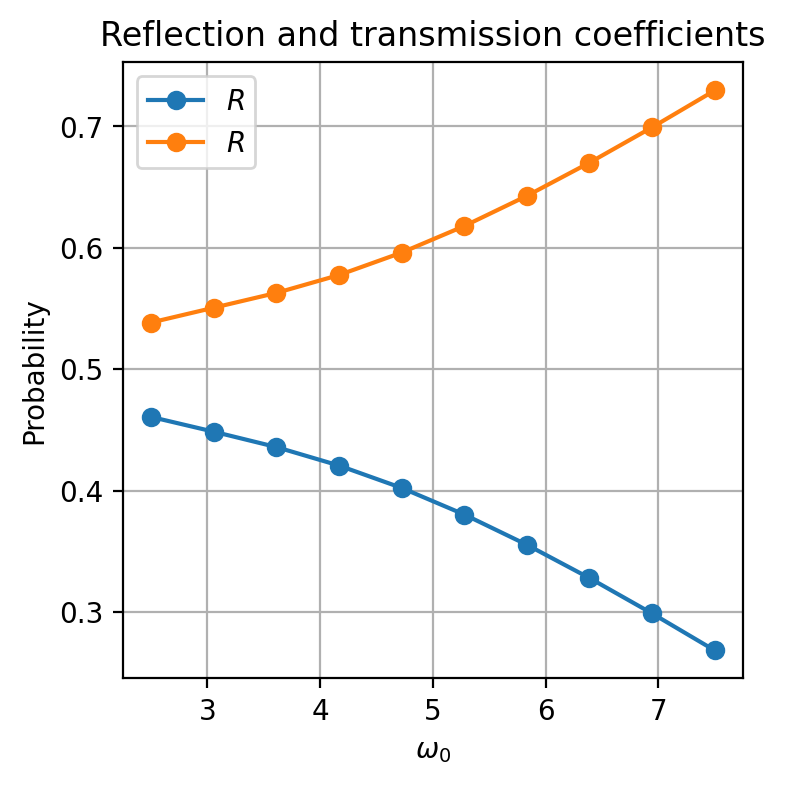

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
ax.plot(omega_0_tab, reflection_coeff, label=r"$R$", marker='o')
ax.plot(omega_0_tab, transmission_coeff, label=r"$R$", marker='o')
ax.set_xlabel(r"$\omega_0$")
ax.set_ylabel("Probability")
ax.set_title("Reflection and transmission coefficients")
ax.grid()
ax.legend()

plt.show()